<a href="https://colab.research.google.com/github/ratimayy/deep/blob/main/CNN1_ex4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic MNIST classification that applies preprocessing **<u>outside the model</u>** (Section 2)

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-402255ba-8c9f-86bc-5fbe-8cf4c6dcf36a)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# To guarantee reproducability, make sure that seed values for ANY randomize operation are all set
#np.random.seed(1234)
#tf.random.set_seed(5678)

In [ ]:
# Choose the model architecture
menu = f'\n1. MLP\n2. CNN\nChoose the model architecture: '

while True:
  model_type = input(menu).strip()
  if model_type in ['1','2']:
    model_type = 'MLP' if (model_type=='1') else 'CNN'
    break


1. MLP
2. CNN
Choose the model architecture: 2


# 2. Prepare the MNIST dataset

## 2.1 Load the dataset

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Inspect the data
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)} " )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}" )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(60000, 28, 28) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(60000,) , min=0 , max=9 
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(10000, 28, 28) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(10000,) , min=0 , max=9


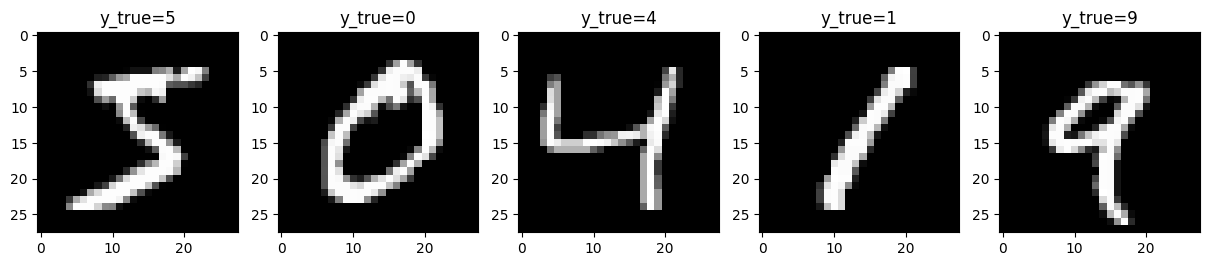

In [ ]:
# Visualize the first five images in x_train
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title( f'y_true={y_train[i]}' )
  plt.imshow( x_train[i] , cmap=plt.get_cmap('gray') )
plt.show()

## 2.2 Preprocess the data

- This example uses simple rescaling. But, in practice, feature normalization is a more popular alternative.

- To perform feature normalization,
  1. Precalculate <u>feature-wise mean and SD values from the train set</u>
  2. Use them for feature normalization during training and inferencing

In [ ]:
# Convert each pixel from unsigned int 8-bit (0-255) data type to 32-bit floating point data type
x_train = x_train.astype( np.float32 )
x_test = x_test.astype( np.float32 )

# Pixel scaling from 0-255 to 0.0-1.0
x_train /= 255
x_test /= 255

# Inspect the data
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(60000, 28, 28) , min=0.0 , max=1.0
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(10000, 28, 28) , min=0.0 , max=1.0


In [ ]:
# Reshape the data
if (model_type == 'MLP'):
  # Dense layer expects an input shape of (batch_size, n_feature)
  n_feature = x_train.shape[1] * x_train.shape[2]
  x_train = np.reshape( x_train, (-1, n_feature) )
  x_test = np.reshape( x_test, (-1, n_feature) )
elif (model_type == 'CNN'):
  # Conv2D layer expects an input shape of (batch_size, n_row, n_col, n_channel)
  img_h, img_w = x_train.shape[1:]
  x_train = np.reshape( x_train, (-1, img_h, img_w, 1) )
  x_test = np.reshape( x_test, (-1, img_h, img_w, 1) )

# Inspect the data
print( f"x_train.shape={x_train.shape} , x_train.dtype={x_train.dtype} , min(x_train)={np.min(x_train)} , max(x_train)={np.max(x_train)}" )
print( f"x_test.shape={x_test.shape} , x_test.dtype={x_test.dtype} , min(x_test)={np.min(x_test)} , max(x_test)={np.max(x_test)}" )

x_train.shape=(60000, 28, 28, 1) , x_train.dtype=float32 , min(x_train)=0.0 , max(x_train)=1.0
x_test.shape=(10000, 28, 28, 1) , x_test.dtype=float32 , min(x_test)=0.0 , max(x_test)=1.0


# 3. Create the network architecture

In [ ]:
def create_mlp( input_dim=(28*28,) ):
  model = tf.keras.models.Sequential()

  # Input layer
  model.add( tf.keras.layers.InputLayer( input_dim, name='input' ) )

  # Hidden layers
  model.add( tf.keras.layers.Dense( 32, activation='relu', name='dense1' ) )
  model.add( tf.keras.layers.Dense( 64, activation='relu', name='dense2' ) )
  model.add( tf.keras.layers.Dense( 128, activation='relu', name='dense3' ) )
  model.add( tf.keras.layers.Dense( 64, activation='relu', name='dense4' ) )
  model.add( tf.keras.layers.Dense( 32, activation='relu', name='dense5' ) )

  # Output layer
  model.add( tf.keras.layers.Dense( 10, activation='softmax', name='output' ) )

  # Compile the model
  model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'] )

  return model

In [ ]:
def create_cnn( input_dim=(28,28,1) ):
  model = tf.keras.models.Sequential()

  # Input layer
  model.add( tf.keras.layers.InputLayer( input_dim, name='input' ) )

  # Feature extractor
  model.add( tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='conv1' ) )
  model.add( tf.keras.layers.Conv2D( filters=64, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='conv2' ) )
  model.add( tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', name='conv3' ) )
  model.add( tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='maxpool1') )

  # Convert 2D feature maps to a 1D vector
  model.add( tf.keras.layers.Flatten() )

  # Classifier
  model.add( tf.keras.layers.Dense( 32, activation='relu', name='dense1' ) )
  model.add( tf.keras.layers.Dense( 10, activation='softmax', name='output' ) )

  # Compile the model
  model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'] )

  return model

In [ ]:
# Create the compiled model
if (model_type == 'MLP'):
  model = create_mlp()
elif (model_type == 'CNN'):
  model = create_cnn()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool1 (MaxPooling2D)              │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 32)                  │         200,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,346 (931.04 KB)

 Trainable params: 238,346 (931.04 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Train the model on train set

In [ ]:
history = model.fit( x_train, y_train,
                     validation_split=0.2,
                     batch_size=128, epochs=10, verbose=1,
                   )

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - acc: 0.8302 - loss: 0.5418 - val_acc: 0.9788 - val_loss: 0.0715
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9813 - loss: 0.0628 - val_acc: 0.9816 - val_loss: 0.0649
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9883 - loss: 0.0386 - val_acc: 0.9862 - val_loss: 0.0475
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9918 - loss: 0.0273 - val_acc: 0.9855 - val_loss: 0.0505
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9943 - loss: 0.0197 - val_acc: 0.9849 - val_loss: 0.0569
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9946 - loss: 0.0163 - val_acc: 0.9884 - val_loss: 0.0452
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9962 - loss: 0.0115 - val_acc: 0.9862 - val_loss: 0.0515
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9966 - loss: 0.0104 - val_acc: 0.9857 - val_loss: 0.0666
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

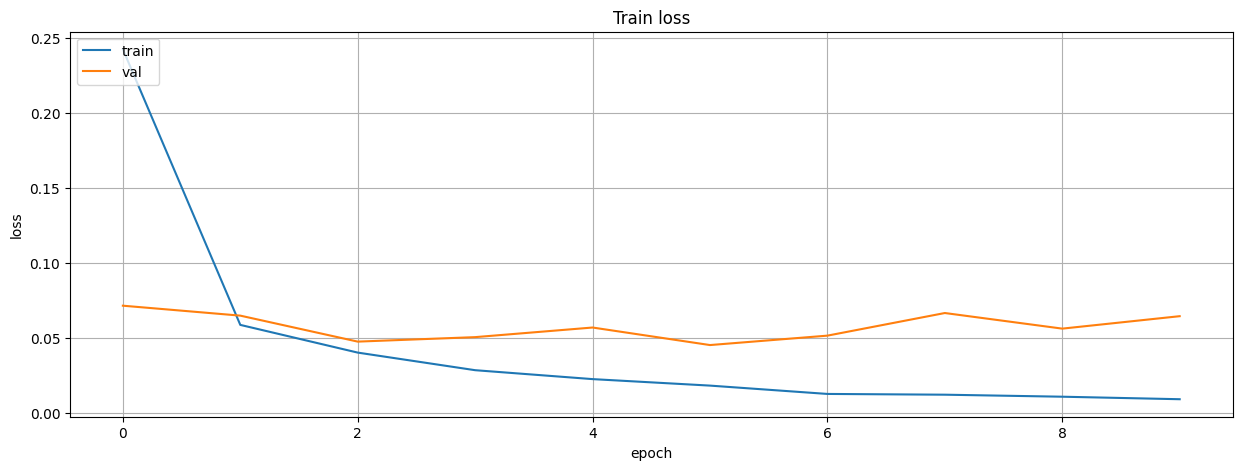

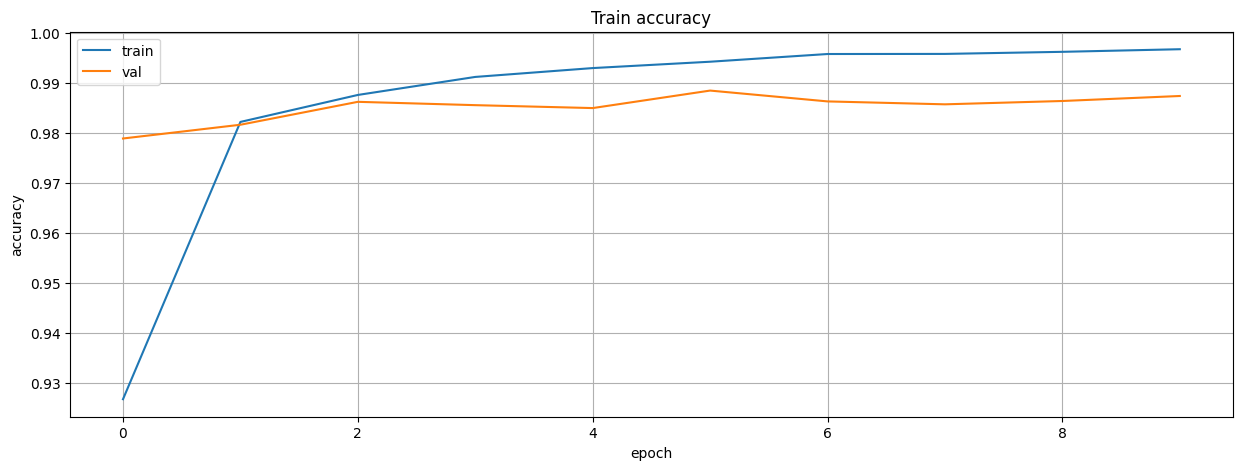

In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# 5. Evaluate the model on test set

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print( f"{model.metrics_names} = {results}" )

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9859 - loss: 0.0758
['loss', 'compile_metrics'] = [0.060783348977565765, 0.9879000186920166]


# 6. Inference

In [ ]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  # Green frame means correct prediction. Red frame means incorrect prediction.
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

one_sample.shape=(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


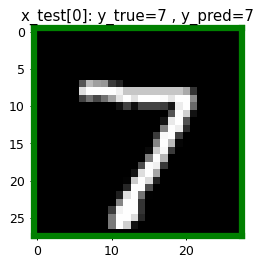

In [ ]:
# Test using the model on one image

# Get one sample
i = 0
one_sample = np.expand_dims(x_test[i], axis=0)
print(f'{one_sample.shape=}')

# Predict one sample
y_pred = model.predict(one_sample)

# Interpret the result
plt.figure(figsize=(3,3), dpi=90)
ax = plt.gca()
ax.imshow( one_sample.reshape(28,28), cmap='gray' )
ax.set_title( f"x_test[{i}]: y_true={y_test[i]} , y_pred={np.argmax(y_pred)}" )
color_frame(ax, y_test[i], np.argmax(y_pred))

samples.shape=(20, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


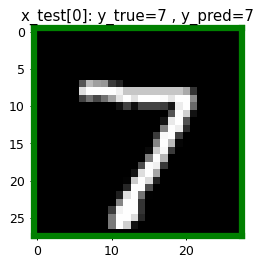

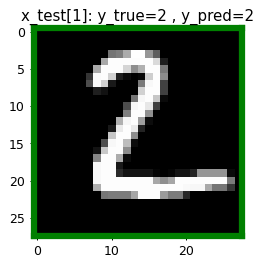

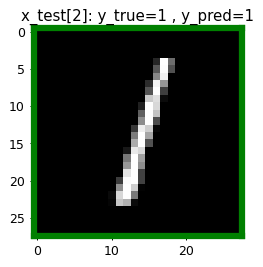

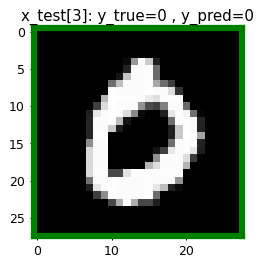

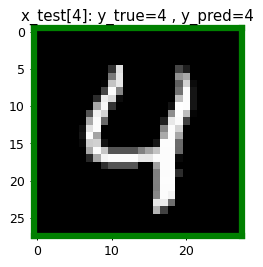

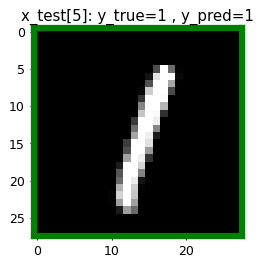

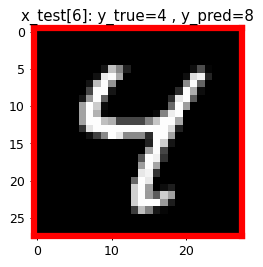

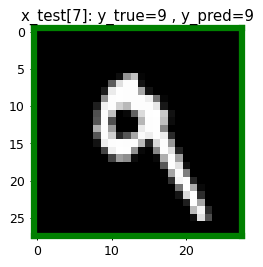

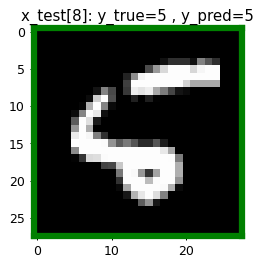

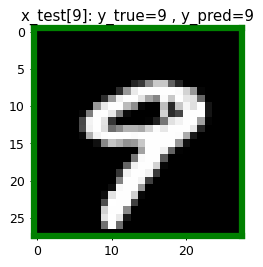

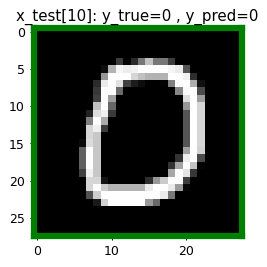

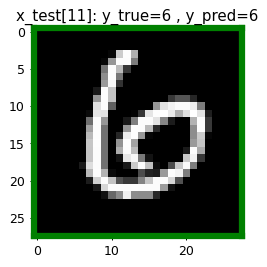

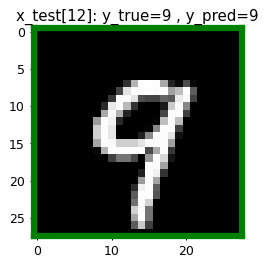

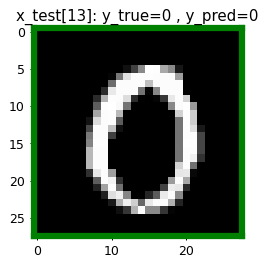

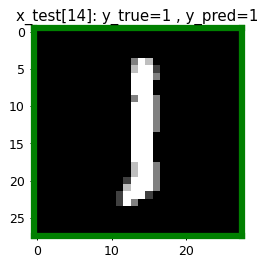

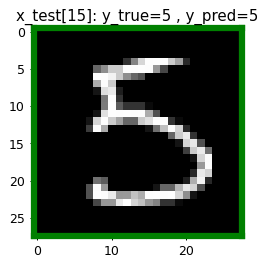

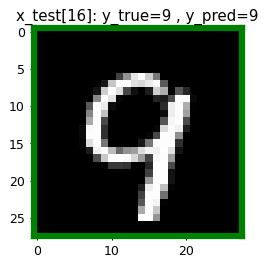

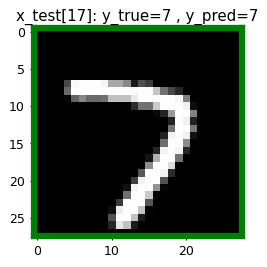

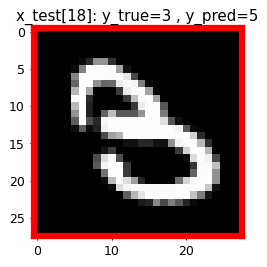

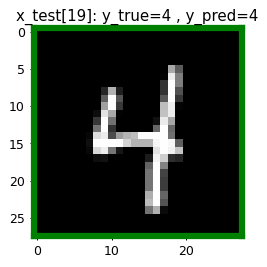

In [ ]:
# Test using the model on many images

# Get a batch of samples
n = 20
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( samples[i].reshape(28,28), cmap='gray' )
  plt.title( f"x_test[{i}]: y_true={y_test[i]} , y_pred={np.argmax(y_pred[i])}" )
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()